## Plain RBC model

This notebook shows how to solve the plain vanilla RBC model using a first order perturbation approach.

A planner solves the problem

\begin{equation}
    \max_{\{c_t,l_t,k_{t+1}\}} E_0 \left[ \sum_{t=0}^{\infty} \beta^t \left( \log c_t - \eta \frac{l_t^{1+\frac{1}{\gamma}}}{1+\frac{1}{\gamma}} \right) \right]
\end{equation}
subject to 
\begin{align}
    c_t + k_{t+1} = & A_t k_t^\alpha l_t^{1-\alpha} + (1-\delta)k_t \\
    \log A_{t+1}  = & \rho \log A_t + \epsilon_{t+1}
\end{align}
where $k_0, A_0$ are given and $\epsilon_t \sim N(0,\sigma^2)$.

Adding a couple of new variables (see notes), the optimality conditions can be written as

\begin{align}
    \frac{1}{c_t} = & \lambda_t \\
    \eta l_t^{\frac{1}{\nu}} = & \lambda_t (1-\alpha) \frac{y_t}{l_t} \\
    \lambda_t = & E_t \left[ \lambda_{t+1} \left( \alpha \frac{y_{t+1}}{k_{t+1}} + 1 - \delta \right) \right] \\
    y_t = & A_t k_t^{\alpha} l_t^{1-\alpha} \\
    y_t = & c_t + x_t \\
    x_t = & k_{t+1} - (1-\delta )k_t \\
    E_t \log A_{t+1} = & \rho \log A_t
\end{align}
where $\lambda_t$ is the Lagrange multiplier on the constraint.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import sys
import statsmodels.api as sm


%matplotlib inline

plt.rcParams['figure.figsize'] = (10,6)


In [2]:
# CALIBRATION AND STEADY STATE VALUES

# Frisch elasticity of labor supply
ν = 1  

# Target values to match steady state quantities

Rbar  = 1.01  # Gross real interest rate per quarter
Lbar  = 1/3   # Steady state labor
XYbar = 0.21  # Average investment/output

# Calibrated parameter values and steady state quantities
α = 1/3       # Capital share in putput
β = 1/Rbar    # Discount factor
δ = (Rbar-1)*XYbar/(α-XYbar)  # Depreciation rate;

Kbar  = Lbar*( α/(Rbar-(1-δ)) )**(1/(1-α))    # Steady state capital
Ybar  = Kbar**α * Lbar**(1-α)                 # Steady state output
Cbar  = Ybar*(1-XYbar)                        # Steady state consumption
Xbar  = δ*Kbar                                # Steady state investment
λbar   = 1/Cbar                               # Steady state multiplier lambda

# Preference parameter eta: but this one disappears from the log-linearized equations!
η = (1-α)*(Ybar/Cbar)/Lbar**(1+1/ν)

# Parameters of technology shocks
ρ = 0.95
σ = 1.019  # standard deviation technology shock. Units: Percent (chosen to match volatility of output in data approx 1.76% from McCallum
# σ = 0.712

# Display calibrated paramters
print(" PARAMETROS CALIBRADOS \n --------------------- ")
print(f"  β =  {β:.2f}")
print(f"  η =  {η:.2f}")
print(f"  ν =  {ν:.2f}")
print(f"  δ =  {δ:.2f}")
print(f"  α =  {α:.2f}")
print(f"  ρ =  {ρ:.2f}")
print(f"  σ =  {σ:.2f} \n")
#print("  β = ", β)
#print("  η = ", η)
#print("  ν = ", ν)
#print("  δ = ", δ)
#print("  α = ", α)
#print("  ρ = ", ρ)
#print("  σ = ", σ, "\n")

print(" VALORES DE ESTADO ESTACIONARIO \n ------------------------------ ")
print(f"  Output      = {Ybar:.2f}")
print(f"  Capital     = {Kbar:.2f}")
print(f"  Investment  = {Xbar:.2f}")
print(f"  Labor       = {Lbar:.2f}")
print(f"  Consumption = {Cbar:.2f}")
print(f"  λ           = {λbar:.2f} \n")
#print("  Output      = ", Ybar)
#print("  Capital     = ", Kbar)
#print("  Investment  = ", Xbar)
#print("  Labor       = ", Lbar)
#print("  Consumption = ", Cbar)
#print("  λ           = ", λbar, "\n")



 PARAMETROS CALIBRADOS 
 --------------------- 
  β =  0.99
  η =  7.59
  ν =  1.00
  δ =  0.02
  α =  0.33
  ρ =  0.95
  σ =  1.02 

 VALORES DE ESTADO ESTACIONARIO 
 ------------------------------ 
  Output      = 1.17
  Capital     = 14.44
  Investment  = 0.25
  Labor       = 0.33
  Consumption = 0.92
  λ           = 1.08 



### Write the first order conditions as a system of first order expectational linear difference equations

We want to express the solution in the form
\begin{equation}
     A E_t \left[ z_{t+1} \right] = B \left[ z_{t} \right]
\end{equation}
Here, all variables should be interpreted as "hats" in the notation of the notes. That is, as percentage deviations for their steady state values.

In this model, we choose the following ordering of the variables in the vector ${z_t}$
\begin{equation}
    z_t = \left[ \hat{k}_t, \hat{A}_t, \hat{y}_t, \hat{c}_t, \hat{l}_t, \hat{x}_t, \hat{\lambda}_t\right]^{\prime}
\end{equation}

#### Linearized equations:
\begin{align}
    0 = & \hat{c}_t + \hat{\lambda}_t \\
    0 = & (1+1/\nu) \hat{l}_t - \hat{\lambda}_t - \hat{y}_t \\
    0 = & \hat{y}_t - \hat{A}_t - \alpha \hat{k}_t - (1-\alpha) \hat{l}_t \\
    0 = & \bar{Y} \hat{y}_t - \bar{C} \hat{c}_t - \bar{X} \hat{x}_t \\
    E_t[\hat{k}_{t+1}] = & (1-\delta )\hat{k}_t + \delta \hat{x} \\
    E_t[\hat{\lambda}_{t+1} + \beta \alpha (\bar{Y}/\bar{K})(\hat{y}_{t+1} - \hat{k}_{t+1})] = &\hat{\lambda}_{t} \\
    E_t[\hat{A}_{t+1}] = & \rho \hat{A}_t 
\end{align}

The matrices $A$ and $B$ are:
\begin{equation}
    A = \begin{bmatrix}
         0 & 0 & 0 & 0 & 0 & 0 & 0  \\
         0 & 0 & 0 & 0 & 0 & 0 & 0  \\
         0 & 0 & 0 & 0 & 0 & 0 & 0  \\
         0 & 0 & 0 & 0 & 0 & 0 & 0  \\
         1 & 0 & 0 & 0 & 0 & 0 & 0  \\
         -\beta \alpha(\bar{Y}/\bar{K}) & 0 & \beta \alpha(\bar{Y}/\bar{K}) & 0 & 0 & 0 & 1  \\
         0 & 1 & 0 & 0 & 0 & 0 & 0  
    \end{bmatrix}    
\end{equation}

\begin{equation}
        B = \begin{bmatrix}
         0 & 0 & 0 & 1 & 0 & 0 & 1  \\
         0 & 0 & -1 & 0 & \left( 1 + \frac{1}{\nu}\right) & 0 & -1  \\
         -\alpha & -1 & 1 & 0 & -(1-\alpha) & 0 & 0  \\
         0 & 0 & \bar{Y} & -\bar{C} & 0 & -\bar{X} & 0  \\
         1-\delta & 0 & 0 & 0 & 0 & \delta & 0  \\
         0 & 0 & 0 & 0 & 0 & 0 & 1  \\
         0 & \rho & 0 & 0 & 0 & 0 & 0  
    \end{bmatrix}
\end{equation}

In [3]:
# CONSTRUCT MATRICES A AND B

A = np.zeros((7,7))
B = np.zeros((7,7))

# FILL ELEMENTS OF A MATRIX (remember that indexes start in 0)

#   Equation 5
A[4,0] = 1                 # k(t+1)

#   Equation 6
A[5,0] = -β*α*Ybar/Kbar    # k(t+1)
A[5,2] =  β*α*Ybar/Kbar    # y(t+1)
A[5,6] = 1                 # λ(t+1) 

#   Equation 7
A[6,1] = 1                 # A(t+1)

# FILL ELEMENTS OF THE B MATRIX 

# Equation 1:
B[0,3] = 1        # c(t)
B[0,6] = 1        # λ(t)

# Equation 2:
B[1,2] = -1       # y(t)
B[1,4] = 1+1/ν    # l(t)
B[1,6] = -1       # λ(t)

# Equation 3:
B[2,0] = -α       # k(t)
B[2,1] = -1       # A(t)
B[2,2] = 1        # y(t)
B[2,4] = -(1-α)   # l(t)

# Equation 4:
B[3,2] = Ybar     # y(t)
B[3,3] = -Cbar    # c(t)
B[3,5] = -Xbar    # x(t)

# Equation 5:
B[4,0] = 1-δ      # k(t)
B[4,5] = δ        # x(t)

# Equation 6:
B[5,6] = 1        # λ(t)

# Equation 7:
B[6,1] = ρ        # A(t)


In [4]:
def solve_ab( A, B, n ):
# SOLVE A FIRST ORDER DIFFERENCE EQUATION USING THE QZ DECOMPOSITION AS IN KLEIN (2000)
# Solves the system A E_t[z_{t+1}] = B z_{t} using the QZ decomposition
# Inputs:
#   A: square matrix
#   B: square matrix (same size as A)
#   n: number of state variables
#
# Note: this is probably not the most efficient implementation of the algorithm.

    S, T, alpha, beta, Q, Z = linalg.ordqz(A, B, sort='ouc')

    Z21 = Z[n:,0:n]
    Z11 = Z[0:n,0:n]

    
    # CHECK BLANCHARD-KAHN CONDITIONS. If violated, send a message and stop.
    
    # Generalized eigenvalues
    geiv  = np.abs(beta/alpha) # Absolute value of generalized eigenvalues
    ngest = np.sum(geiv < 1)   # Number of stable generalized eigenvalues

    if ngest<n:
        sys.exit('Blanchard and Kahn condition violated: no existence of equilibrium')

    if ngest>n:
        sys.exit('Blanchard and Kahn condition violated: multiple equilibria. Think for a moment what you want to do with this')

    # FIND SOLUTION
    if np.linalg.matrix_rank(Z11) < n:
            sys.exit('Invertibility condition violated')

    Z11i = linalg.inv(Z11)
    S11  = S[0:n,0:n]
    T11  = T[0:n,0:n]

    if ( np.abs( T[n-1,n-1] ) > np.abs( S[n-1,n-1] ) ) | ( np.abs(T[n,n]) < np.abs(S[n,n]) ):
            print("Wrong number of stable eigenvalues.")

    S11i = linalg.inv(S11)        

    F = np.real(Z21@Z11i)
    P = np.real(Z11@ ( (S11i@T11) @ Z11i ))

    
    return F, P

In [5]:
# Solve model and find policy functions

n = 2  # 2 state variables
F, P = solve_ab( A, B, n ) 

print(" Control variables policy functions of the calibrated RBC model: Matrix F ")
print(F)

print(" \n State variables policy functions of the calibrated RBC model: Matrix P ")
print(P)


varnames =['Capital',
           'TFP',
           'Output',
           'Consumption',
           'Labor',
           'Investment',
           'lambda']


 Control variables policy functions of the calibrated RBC model: Matrix F 
[[ 0.21696412  1.33147665]
 [ 0.56607176  0.3370467 ]
 [-0.17455382  0.49721498]
 [-1.09634558  5.07242742]
 [-0.56607176 -0.3370467 ]]
 
 State variables policy functions of the calibrated RBC model: Matrix P 
[[0.96430547 0.08636836]
 [0.         0.95      ]]


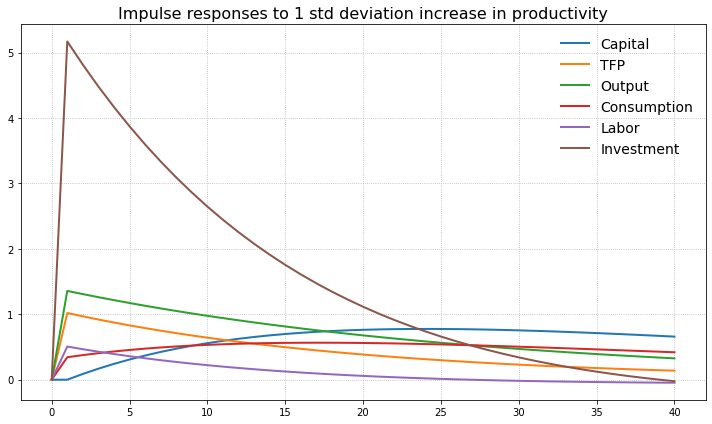

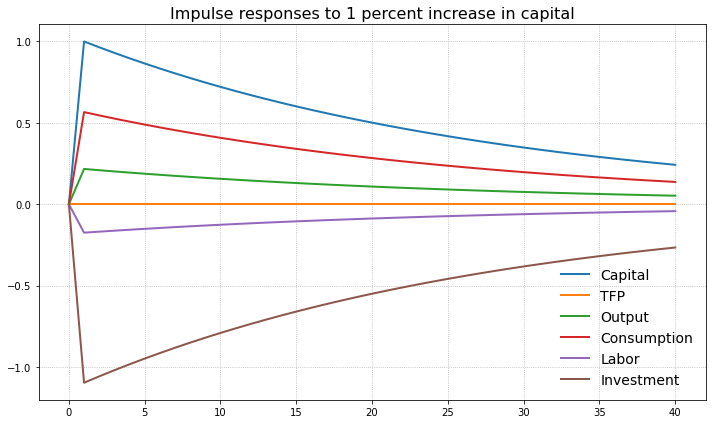

In [6]:
# COMPUTE IMPULSE RESPONSES

#  Number of periods to simulate the model
T = 41

#  IMPULSE TO A TECHNOLOGY SHOCK
#  Initialize storage arrays
irk_a = np.zeros(T+1)
ira_a = np.zeros(T+1)
iry_a = np.zeros(T)
irc_a = np.zeros(T)
irl_a = np.zeros(T)
irx_a = np.zeros(T)

ϵ_shock = np.zeros(T+1)
ϵ_shock[0] = σ  # impulso de 1 std deviation

for t in range(T):
    irk_a[t+1] = irk_a[t]*P[0,0] + ira_a[t]*P[0,1]
    ira_a[t+1] = ira_a[t]*P[1,0] + ira_a[t]*P[1,1] + ϵ_shock[t]
    iry_a[t]   = irk_a[t]*F[0,0] + ira_a[t]*F[0,1]
    irc_a[t]   = irk_a[t]*F[1,0] + ira_a[t]*F[1,1]
    irl_a[t]   = irk_a[t]*F[2,0] + ira_a[t]*F[2,1]
    irx_a[t]   = irk_a[t]*F[3,0] + ira_a[t]*F[3,1]

# MAKE PLOT    
fig, ax = plt.subplots()
ax.set_title('Impulse responses to 1 std deviation increase in productivity', fontsize = 16)
ax.plot(irk_a[:-1], linewidth = 2, label = varnames[0])
ax.plot(ira_a[:-1], linewidth = 2, label = varnames[1])
ax.plot(iry_a, linewidth = 2, label = varnames[2])
ax.plot(irc_a, linewidth = 2, label = varnames[3])
ax.plot(irl_a, linewidth = 2, label = varnames[4])
ax.plot(irx_a, linewidth = 2, label = varnames[5])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()
    
    
#  IMPULSE TO AN INCREASE IN CAPITAL
#  Initialize storage arrays
irk_k = np.zeros(T+1)
ira_k = np.zeros(T+1)
iry_k = np.zeros(T)
irc_k = np.zeros(T)
irl_k = np.zeros(T)
irx_k = np.zeros(T)

k_shock    = np.zeros(T+1)
k_shock[0] = 1  # impulso de 1 percentage point

for t in range(T):
    irk_k[t+1] = irk_k[t]*P[0,0] + ira_k[t]*P[0,1] + k_shock[t] 
    ira_k[t+1] = ira_k[t]*P[1,0] + ira_k[t]*P[1,1]
    iry_k[t]   = irk_k[t]*F[0,0] + ira_k[t]*F[0,1]
    irc_k[t]   = irk_k[t]*F[1,0] + ira_k[t]*F[1,1]
    irl_k[t]   = irk_k[t]*F[2,0] + ira_k[t]*F[2,1]
    irx_k[t]   = irk_k[t]*F[3,0] + ira_k[t]*F[3,1]

    
# MAKE PLOT    
fig, ax = plt.subplots()
ax.set_title('Impulse responses to 1 percent increase in capital', fontsize = 16)
ax.plot(irk_k[:-1], linewidth = 2, label = varnames[0])
ax.plot(ira_k[:-1], linewidth = 2, label = varnames[1])
ax.plot(iry_k, linewidth = 2, label = varnames[2])
ax.plot(irc_k, linewidth = 2, label = varnames[3])
ax.plot(irl_k, linewidth = 2, label = varnames[4])
ax.plot(irx_k, linewidth = 2, label = varnames[5])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()

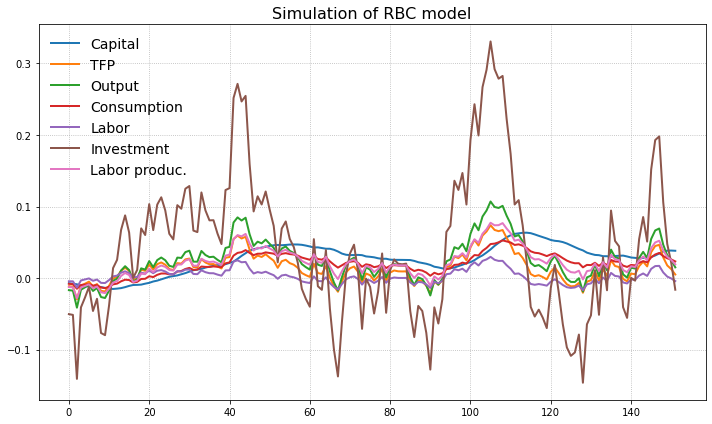

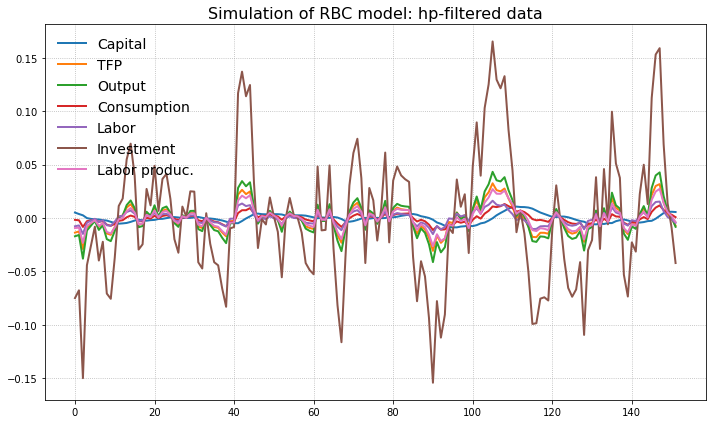

In [7]:
# NOW PERFORM A SIMULATION OF THE MODEL
T  = 100000 # Very long time series
Tp = 151    # Periods to plot
T0 = 100    # Initial period to start plotting shorter series

#  Initialize storage arrays
k_sim = np.zeros(T+1)
a_sim = np.zeros(T+1)
y_sim = np.zeros(T)
c_sim = np.zeros(T)
l_sim = np.zeros(T)
x_sim = np.zeros(T)

# Draw technology shocks
ϵ_shock = (σ/100)*np.random.randn(T+1)

for t in range(T):
    k_sim[t+1] = k_sim[t]*P[0,0] + a_sim[t]*P[0,1]
    a_sim[t+1] = a_sim[t]*P[1,0] + a_sim[t]*P[1,1] + ϵ_shock[t]
    y_sim[t]   = k_sim[t]*F[0,0] + a_sim[t]*F[0,1]
    c_sim[t]   = k_sim[t]*F[1,0] + a_sim[t]*F[1,1]
    l_sim[t]   = k_sim[t]*F[2,0] + a_sim[t]*F[2,1]
    x_sim[t]   = k_sim[t]*F[3,0] + a_sim[t]*F[3,1]

labor_productivity_sim = y_sim - l_sim

varnames =['Capital',
           'TFP',
           'Output',
           'Consumption',
           'Labor',
           'Investment',
           'Labor produc.']


# PLOT SIMULATIONS WITHOUT FILTERING
fig, ax = plt.subplots()
ax.set_title('Simulation of RBC model', fontsize = 16)
ax.plot(k_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[0])
ax.plot(a_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[1])
ax.plot(y_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[2])
ax.plot(c_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[3])
ax.plot(l_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[4])
ax.plot(x_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[5])
ax.plot(labor_productivity_sim[T0:T0+Tp+1], linewidth = 2, label = varnames[6])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()


# NOW PLOT HP-FiLTERED SIMULATED DATA
lamb_hp = 1600
k_cycle, garb = sm.tsa.filters.hpfilter( k_sim, lamb_hp)
a_cycle, garb = sm.tsa.filters.hpfilter( a_sim, lamb_hp)
y_cycle, garb = sm.tsa.filters.hpfilter( y_sim, lamb_hp)
c_cycle, garb = sm.tsa.filters.hpfilter( c_sim, lamb_hp)
l_cycle, garb = sm.tsa.filters.hpfilter( l_sim, lamb_hp)
x_cycle, garb = sm.tsa.filters.hpfilter( x_sim, lamb_hp)
labor_productivity_cycle, garb = sm.tsa.filters.hpfilter( labor_productivity_sim, lamb_hp)

# PLOT SIMULATIONS WITHOUT FILTERING
fig, ax = plt.subplots()
ax.set_title('Simulation of RBC model: hp-filtered data', fontsize = 16)

ax.plot(k_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[0])
ax.plot(a_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[1])
ax.plot(y_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[2])
ax.plot(c_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[3])
ax.plot(l_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[4])
ax.plot(x_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[5])
ax.plot(labor_productivity_cycle[T0:T0+Tp+1], linewidth = 2, label = varnames[6])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()





In [8]:
## COMPUTE MOMENTS
data = {'Capital'    : k_cycle[:-1], 
        'TFP'        : a_cycle[:-1],
        'Output'     : y_cycle,
        'Consumption': c_cycle,
        'Labor'      : l_cycle,
        'Investment' : x_cycle,
        'Labor prod.': labor_productivity_cycle} 


df = pd.DataFrame(data,columns=['Capital',  'TFP', 'Output', 'Consumption','Labor','Investment','Labor prod.'])

volatility = df.std()
correlation = df.corr()

print(' Std deviation as percentage departure from trend (HP filtered)')
print(' ==============================================================')
print(volatility)

print('\n\n Correlation matrix  (HP filtered)')
print(' ======================================')
print(correlation)



 Std deviation as percentage departure from trend (HP filtered)
Capital        0.004091
TFP            0.013315
Output         0.017737
Consumption    0.005016
Labor          0.006671
Investment     0.067763
Labor prod.    0.011197
dtype: float64


 Correlation matrix  (HP filtered)
              Capital       TFP    Output  Consumption     Labor  Investment  \
Capital      1.000000 -0.016443  0.033596     0.446937 -0.123378   -0.082586   
TFP         -0.016443  1.000000  0.998746     0.887095  0.994252    0.997805   
Output       0.033596  0.998746  1.000000     0.909076  0.987655    0.993247   
Consumption  0.446937  0.887095  0.909076     1.000000  0.832588    0.854599   
Labor       -0.123378  0.994252  0.987655     0.832588  1.000000    0.999159   
Investment  -0.082586  0.997805  0.993247     0.854599  0.999159    1.000000   
Labor prod.  0.126719  0.989719  0.995636     0.943989  0.968726    0.978085   

             Labor prod.  
Capital         0.126719  
TFP             0.989

### Unconditional second moments
The solution of the model gives policy functions of the form
\begin{align}
    x_{t+1} = & P x_{t} + \eta \epsilon_{t+1} \\
    y_{t}   = & F x_{t}
\end{align}

The unconditional covariance matrix of the state variables solves the following equation:
\begin{equation}
    \Sigma_x = P \Sigma_x P^{\prime} + \Sigma_{\epsilon}
\end{equation}

The closed form solution uses the vec operator: find the vector $vec(\Sigma_x)$ that solves 
\begin{equation}
    vec(\Sigma_x) = (P \otimes P) vec(\Sigma_x) + vec(\Sigma_{\epsilon})
\end{equation}
or
\begin{equation}
    (I - P \otimes P)vec(\Sigma_x) = vec(\Sigma_{\epsilon})
\end{equation}

The solution can also be found using iteration as explained in the notes.


 Unconditional covariance matrix of the state vector [k(t) a(t)]: 
 
 Using kronecker product:
[[0.00258729 0.00104138]
 [0.00104138 0.00106499]]
 

 Using iterative procedure:
[[0.00258729 0.00104138]
 [0.00104138 0.00106499]]


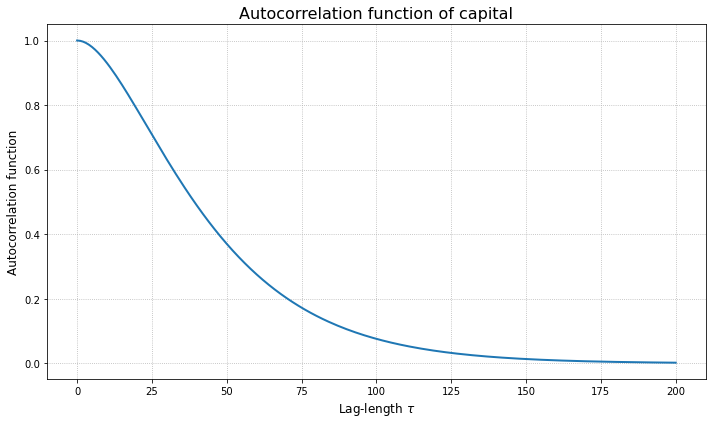

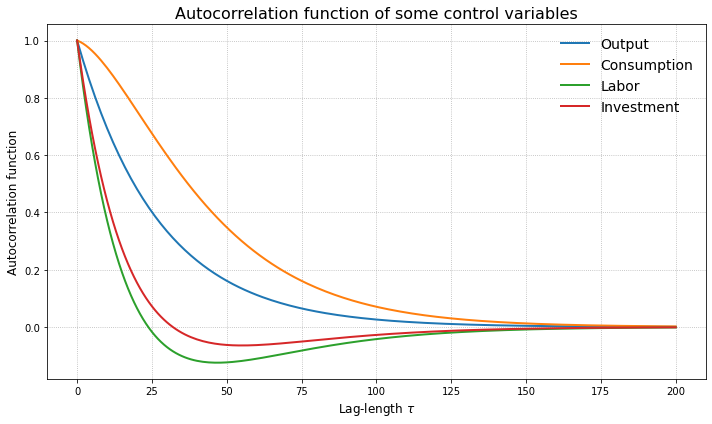

In [9]:
# Compute population moments using formula in the notes and through iteration

ETA_vec = np.array([0,σ/100])
Sigma_eps = np.outer(ETA_vec, ETA_vec)

# Vectorize SigEps matrix
SigEps_vec = Sigma_eps.reshape((-1, 1), order="F")

SigmaX_vec = linalg.solve(np.eye(4)-np.kron(P,P), SigEps_vec)

SigmaX = np.reshape(SigmaX_vec, (-1, 2))
print(" Unconditional covariance matrix of the state vector [k(t) a(t)]: \n ")
print(" Using kronecker product:")
print(SigmaX)

# Using iteration
Sigma0 = np.eye(2)
error = 1

while error > 1e-7:
    Sigma1 = P*Sigma0*P.T + Sigma_eps
    error = np.linalg.norm(Sigma1-Sigma0)
    Sigma0 = Sigma1
    
print(" \n\n Using iterative procedure:")
print(SigmaX)

# Autocovariances of X
nTau = 200
SigmaX_tau = np.zeros([len(SigmaX),len(SigmaX),nTau+1])

# Initialize first element to unconditional variance
SigmaX_tau[:,:,0] = SigmaX

for it in range(nTau):
    SigmaX_tau[:,:,it+1] = P@SigmaX_tau[:,:,it]

# Autocorrelation of capital (divido autocavianzas del capital por su varianza)    
autocorr_k = SigmaX_tau[0,0,:]/SigmaX_tau[0,0,0]    
    
fig, ax = plt.subplots()
ax.set_title('Autocorrelation function of capital', fontsize = 16)
ax.plot(autocorr_k, linewidth = 2, label = varnames[0])
ax.grid(linestyle='dotted')
ax.set_xlabel(r'Lag-length $\tau$ ', fontsize=12)
ax.set_ylabel('Autocorrelation function', fontsize = 12)
fig.tight_layout()
plt.show()


# Second moments of the control variables
SigmaY_tau = np.zeros([len(F),len(F),nTau+1])

for it in range(nTau+1):
    SigmaY_tau[:,:,it] = F @ SigmaX_tau[:,:,it] @ F.T
    
# Autocorrelation function of some control variables
autocorr_y = SigmaY_tau[0,0,:]/SigmaY_tau[0,0,0]  # Output
autocorr_c = SigmaY_tau[1,1,:]/SigmaY_tau[1,1,0]  # Consumption
autocorr_l = SigmaY_tau[2,2,:]/SigmaY_tau[2,2,0]  # Labor
autocorr_x = SigmaY_tau[3,3,:]/SigmaY_tau[3,3,0]  # Investment


fig, ax = plt.subplots()
ax.set_title('Autocorrelation function of some control variables', fontsize = 16)
ax.plot(autocorr_y, linewidth = 2, label = varnames[2])
ax.plot(autocorr_c, linewidth = 2, label = varnames[3])
ax.plot(autocorr_l, linewidth = 2, label = varnames[4])
ax.plot(autocorr_x, linewidth = 2, label = varnames[5])
ax.set_xlabel(r'Lag-length $\tau$ ', fontsize=12)
ax.set_ylabel('Autocorrelation function', fontsize = 12)
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()


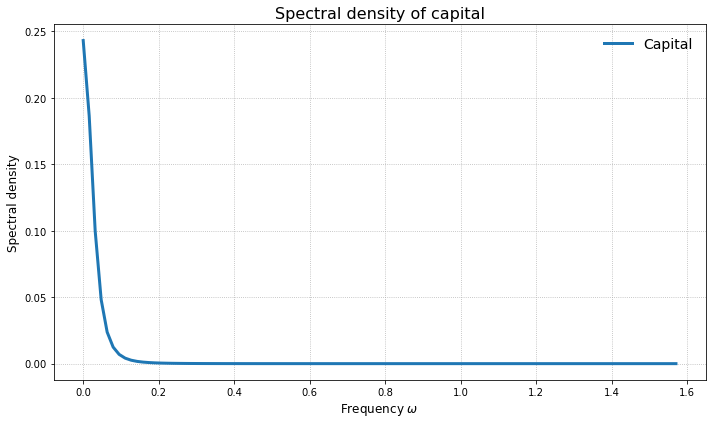

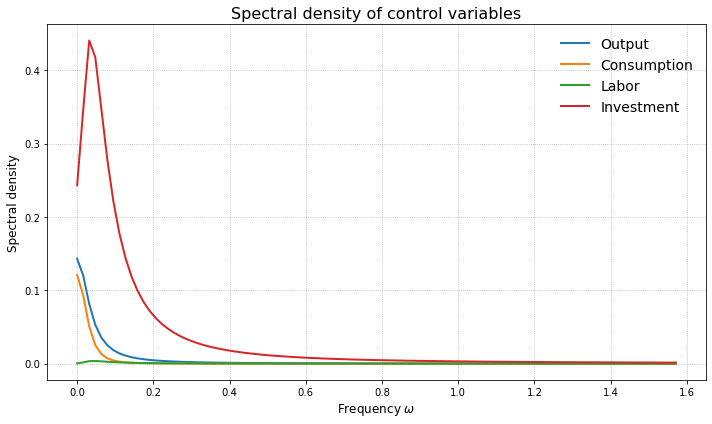

In [10]:
# Spectra densities
n_ω_grid = 100
ω_grid = np.linspace(0, np.pi/2, n_ω_grid)
Ip = np.eye(len(P))

# Need to specify that the matrix is for storing complex numbers
Spectral_X = np.empty([len(SigmaX),len(SigmaX),n_ω_grid],dtype=np.complex_)  

for ix in range(n_ω_grid):
    Spectral_X[:,:,ix] = np.linalg.inv(Ip-P*np.exp(-1j*ω_grid[ix])) @ Sigma_eps @ np.linalg.inv(Ip-P.T*np.exp(1j*ω_grid[ix]))
    
# SPECTRAL DENSITY OF CAPITAL AND TFP SHOCK:
SpectralDensity_k = np.real(Spectral_X[0,0,:])
SpectralDensity_a = np.real(Spectral_X[1,1,:])

fig, ax = plt.subplots()
ax.set_title('Spectral density of capital', fontsize = 16)
ax.plot(ω_grid,SpectralDensity_k, linewidth = 3, label = varnames[0])
#ax.plot(ω_grid,SpectralDensity_a, linewidth = 2, label = varnames[1])
ax.set_ylabel(r'Spectral density', fontsize=12)
ax.set_xlabel(r'Frequency $\omega$', fontsize = 12)
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()

# SPECTRAL DENSITY OF CONTROL VARIABLES
Spectral_Y = np.empty([len(F),len(F),n_ω_grid],dtype=np.complex_)  
for ix in range(n_ω_grid):
    Spectral_Y[:,:,ix] = F @ Spectral_X[:,:,ix] @ F.T

SpectralDensity_y = np.real(Spectral_Y[0,0,:])
SpectralDensity_c = np.real(Spectral_Y[1,1,:])
SpectralDensity_l = np.real(Spectral_Y[2,2,:])
SpectralDensity_x = np.real(Spectral_Y[3,3,:])

fig, ax = plt.subplots()
ax.set_title('Spectral density of control variables', fontsize = 16)
ax.plot(ω_grid,SpectralDensity_y, linewidth = 2, label = varnames[2])
ax.plot(ω_grid,SpectralDensity_c, linewidth = 2, label = varnames[3])
ax.plot(ω_grid,SpectralDensity_l, linewidth = 2, label = varnames[4])
ax.plot(ω_grid,SpectralDensity_x, linewidth = 2, label = varnames[5])
ax.set_ylabel(r'Spectral density', fontsize=12)
ax.set_xlabel(r'Frequency $\omega$', fontsize = 12)
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.show()